In [2]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

6-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"
 "../src"
 "../src"
 "/home/ubuntu/workspace/Gen-Distribution-Zoo/src"

In [3]:
#nbx
using BenchmarkTools;
using LaTeXStrings
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt # Contains Python style f string
using MyUtils
using GenDistributionZoo: diagnormal
include("../src/pose.jl");
include("src/sensor_b.jl");

argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));
nice_f(x) = f"{$x:0.2f}";

## CSAIL Data

In [6]:
include("src/csail_data.jl")

Loading `../data/mit-csail.json` ...

	_zs 	Vector{Vector{Float64}}
	_zs_inf 	Vector{Vector{Float64}}
	_as 	Vector{Float64}
	_zmax 	Float64
	_ys 	Vector{Vector{Vector{Float64}}}
	_ys_inf 	Vector{Vector{Vector{Float64}}}
	_num_a 	Int64
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


## Plotting

In [7]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end;

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    myplot=nothing
    for (p,c) in zip(ps,cs)
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
    return myplot
end;

function Plots.plot!(ps::Vector{Pose}; r=0.5, args...)
    myplot=nothing
    for p in ps
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
    end
    return myplot
end;

## Model parts

### Motion model

In [8]:
#nbx
"""
    q = motion_model(p, u, x_noise, hd_noise)

Sample a new pose `q` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise`.
"""
@gen function motion_model(p, u, x_noise, hd_noise)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return Pose(x, hd)
end;

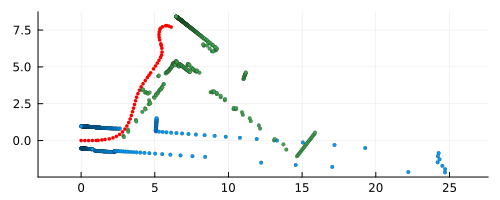

In [10]:
t1 = 1_050
t2 = t1 + 50

ps = Pose[_ps[t1]]

for u in _us[t1:t2]
    p = motion_model(ps[end], u, 1e-4, 1e-4)       
    push!(ps, p)
end
ps = [p/ps[1] for p in ps]

# --------
plot(size=(500,200), legend=nothing, aspect_ratio=:equal)
scatter!([p.x for p in ps], c=:red, markersize=2, markerstrokewidth=0)
scatter!(_ys[t1], c=col[1], markersize=2, markerstrokewidth=0.5)
scatter!(_ys[t2].*ps[end], c=col[3], markersize=2, markerstrokewidth=0.5)

### Sensor model

In [11]:
#nbx
as_ = CuArray(_as)
"""
    x = sensor_model_cu(p, ys, w, s_noise, outlier, outliver_vol, zmax)

"""
@gen function sensor_model_cu(p, ys, w, s_noise, outlier, outliver_vol, zmax)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)
    ys_ = CuArray(stack(ys))
    
    # Deterministic measurement at 
    # poses `ps_` given the point-cloud-map `ys_`
    zs_ = cast_cu(ps_, ys_; fov=π, zmax=zmax, cell_rad=0.01)
    
    # Compute gaussian mixture components `y_tilde_`, and
    # sample an observation
    y_tilde_ = get_ys_tilde_cu(zs_, as_, w)[1,:,:,:]
    x = {:x} ~ sensordist_cu(y_tilde_, s_noise, outlier, outliver_vol)

    return x
end;

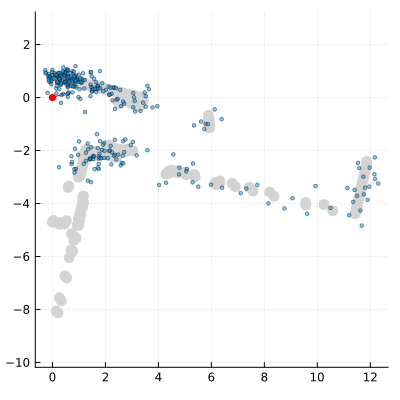

In [18]:
w            = 10
s_noise      = 0.3
outlier      = 0.1
outliver_vol = 1.0
zmax         = Inf

t = 1_100
p = Pose(0, 0, π/10)

args = (p, _ys[t], w, s_noise, outlier, outliver_vol, zmax)

tr = simulate(sensor_model_cu, args);
x = tr[];

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
scatter!(_ys[t], c=:lightgray, markerstrokewidth=0, markersize=6)
scatter!(p, r=0.5)
scatter!(x.*p, c=col[1], alpha=0.5, markersize=2)

## Single Step Model

In [16]:
@gen function step_model(y, u, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
    
        p  = {:pose}   ~ motion_model(Pose(), u, x_noise, hd_noise)
        x  = {:sensor} ~ sensor_model_cu(p, y, w, s_noise, outlier, outliver_vol)
        
    return (p, x)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##step_model#648", Bool[0, 0, 0, 0, 0, 0, 0, 0], false)

In [17]:
#nbx
get_pose(tr) = tr[][1]

function constraints(t::Int)
    ch = choicemap((:sensor => :x) => _ys[t])
    return ch
end

constraints (generic function with 1 method)

In [ ]:
s = 4
i = 0
t1 = 1_050 + i*s
t2 = t1 + s

# Integrate controls over step size
ux  = sum([u.dx  for u in _us[t1:t2-1]])
uhd = sum([u.dhd for u in _us[t1:t2-1]])
u = Control( rot(-_hds[t1])*ux, uhd)

# Reference point cloud (the map)
# and observation to be explained
y = _ys[t1]
x = _ys[t2]
ch = choicemap()
ch[:sensor => :x] = x

# Motion args
x_noise  = 0.4
hd_noise = 10/360*2π

# Sensor args
w           = 25
s_noise     = 0.1
outlier     = 1e-6
outlier_vol = 1.0

args=(y, u, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)

step_model(args...)
@time simulate(step_model, args)

### Importance Sampling

In [ ]:
N = 1_000

@time trs, ws, lml = importance_sampling(step_model, args, ch, N);

perm = sortperm(ws)
trs = trs[perm]
ws  = ws[perm];
scores = get_score.(trs);

ps = get_pose.(trs)
cs = cgrad(:viridis)[peak_to_peak(ws)]

# --------------------
display(plot(ws, size=(200,100)))

# ------------------
mypl = plot(legend=nothing, aspect_ratio=:equal, title="w=$(w) - s_noise=$(s_noise) - outl.=$(outlier)")
plot!(ps, cs, linewidth=3)
scatter!(_ys[t1], markersize=6, markerstrokewidth=0, c=col[1])
# scatter!(_ys[t], markersize=6, markerstrokewidth=0, c=:white)
scatter!(_ys[t2].*ps[end], markersize=3, markerstrokewidth=0, c=:magenta)
mypl

### Odometry correction - IS

In [ ]:
# Number of importance samples, 
# should be the same as the number of  
# evals in the SMC version below
N = 3_000 

ps = []
xs = []
ts = []
for i=1:30

    s = 4
    t1 = 1_110 + i*s
    t2 = t1 + s

    # Integrate controls over step size
    ux  = sum([u.dx  for u in _us[t1:t2-1]])
    uhd = sum([u.dhd for u in _us[t1:t2-1]])
    u = Control( rot(-_hds[t1])*ux, uhd)

    # Reference point cloud (the map)
    # and observation to be explained
    y = _ys[t1]
    x = _ys[t2]
    ch = choicemap()
    ch[:sensor => :x] = x


    x_noise  = 0.4
    hd_noise = 10/360*2π

    w           = 25
    s_noise     = 0.05
    outlier     = 1e-3
    outlier_vol = 1.0

    args = (y, u, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
    @time trs, ws, lml = importance_sampling(step_model, args, ch, N);

    perm   = sortperm(ws)
    trs    = trs[perm]
    ws     = ws[perm];
    scores = get_score.(trs);

    tr = trs[end]
    push!(ps, tr[][1])
    push!(xs, tr[][2])
    push!(ts, t1)
end

In [ ]:
p_ref = Pose()
qs = Pose[]

for p in ps
    push!(qs, p*p_ref)
    p_ref = p*p_ref
end

# ------------------------
mypl = plot(aspect_ratio=:equal, legend=nothing, title="Combined observations after\n odometry correction - IS (N=$(N))")
plot!(qs, c=:red)
for (x,q) in zip(xs, qs)
    scatter!(x.*q, markersize=1, markerstrokewidth=0, c=col[1])
end
savefig("_imgs/odometry_correction_IS.png")
mypl

In [ ]:
layout_shape = (div(length(ts),5), 5)
plts = []
for (t,x,p) in zip(ts,xs,ps)
    mypl = plot(size=(200,200), legend=nothing, aspect_ratio=:equal, title="t=$(t)")
    scatter!(_ys[t], markersize=4, markerstrokewidth=0, c=col[1])
    scatter!(x.*p, markersize=2, markerstrokewidth=0, c=:magenta)
    push!(plts,mypl)
end

plot(plts..., layout=layout_shape, size=layout_shape.*200, plot_title="Odometry correction - IS (N=$(N))")

## SMC grid proposal

### Pose grid

Define a grid of poses around a reference pose.

In [10]:
#nbx --fname="src/grid_proposal.jl"
"""
    ps_ = pose_grid(p, k, dx, dhd)

Returns CuArray of pose vectors (k^3, 3).
"""
function pose_grid(p, k, dx, dhd)
    dx1_ = CUDA.collect(CUDA.range(- dx,  dx, k))
    dx2_ = CUDA.collect(CUDA.range(- dx,  dx, k))
    dhd_ = CUDA.collect(CUDA.range(-dhd, dhd, k))
    dx1_ = CuArray(dx1_)
    dx2_ = CuArray(dx2_)
    dhd_ = CuArray(dhd_)
    dx1_ = CUDA.repeat(reshape(dx1_, k,1,1), 1,k,k)
    dx2_ = CUDA.repeat(reshape(dx2_, 1,k,1), k,1,k)
    dhd_ = CUDA.repeat(reshape(dhd_, 1,1,k), k,k,1)

    ps_ = CUDA.cat(dx1_, dx2_, dhd_, dims=4)
    ps_ = reshape(ps_, :,3)
    ps_ = ps_ .+ reshape(CuArray(Vector(p)),1,3)
    
    return ps_
end

pose_grid

In [ ]:
p = Pose([0;0],π/4)

dx  = .5
dhd = 45/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(ps, c=:blue, r=0.1, linewidth=1)
plot!(p, c=:red, r=0.1, linewidth=2)
mypl

### Eval pose grid

This depends on `"src/sensor_b.jl"` which is included above in the "Sensor model" section above.

In [11]:
#nbx
"""
    ps, log_ps = eval_poses(
                    ps_::CuArray,
                    x::Matrix, 
                    ys_::CuArray, as_::CuArray, w::Int, 
                    s_noise::Float64, outlier::Float64, 
                    outlier_vol::Float64=1.0, zmax::Float64=100.0; sorted=false)

Evaluates a collection of poses 
with respect to different Gaussian mixtures...
"""
function eval_poses(
            ps_::CuArray,
            x_::CuArray, 
            ys_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0, 
            zmax::Float64=100.0; sorted=false)
    
    # Compute sensor measurements and 
    # Gaussian mixture components
    zs_       = cast_cu(ps_, ys_; fov=π, zmax=zmax, cell_rad=0.01)
    ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)
        
    # Evaluate the the observations with respect to the 
    # different Gaussian mixtures computed above
    log_ps_, = sensor_smc_logpdf_cu(x_, ys_tilde_, s_noise, outlier, outlier_vol);
    
    # Move everyting back to CPU
    ps     = Vector.(eachrow(Array(ps_)))
    log_ps = Array(log_ps_)

    # Sort by log prob
    # and return 
    if sorted
        perm   = sortperm(log_ps)
        log_ps = log_ps[perm]
        ps     = ps[perm]
    end
    
    return ps, log_ps
end;

In [ ]:
t = 1060
s = 5

# Integrate the controls 
# for each time step t=1,...,s
ux  = sum([u.dx  for u in _us[t:t+s-1]])
uhd = sum([u.dhd for u in _us[t:t+s-1]])
u   = Control( rot(-_hds[t])*ux, uhd)

# Center of the grid
p   = Pose(u.dx, u.dhd)
dx  = 2.
dhd = 25/360*2π
k   = 15

# Create the grid and 
# set the observation and map
@time ps_ = pose_grid(p, k, dx, dhd)
x_  = CuArray(stack(_ys[t+s]))
ys_ = CuArray(stack(_ys[t]))

# Sensor args
s_noise     = 0.05
outlier     = 1e-6
outlier_vol = 1.0
zmax = 100.0
w = 15

# Evaluate
@time ps, log_ps = eval_poses(ps_, x_, ys_, 
                        as_, w, s_noise, outlier, outlier_vol, zmax; sorted=true)

# -----------------------------
display(plot(log_ps, size=(200,100)))
# -----------------------------
mypl = plot(size=(500,500), legend=nothing, 
            aspect_ratio=:equal, xlim=(-5,15), ylim=(-8,8))

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
plot!(Pose.(ps), cs; r=.5, linewidth=1)
scatter!(_ys[t], markerstrokewidth=0, c=col[1], markersize=4)
scatter!(_ys[t+s] .* Pose(ps[end]), markerstrokewidth=0, c=:magenta, markersize=2)
plot!(Pose(), c=:red, r=.5, linewidth=3)
# annotate!(10, 0, text("outlier=$(outlier)", :darkgreen, :center, 11))
mypl

### Grid proposal

Generative functions to create proposals from a pose grid &mdash; one step in the coarse-to-fine SMC proposal defined later.

In [12]:
#nbx
function filter_infs(ps, log_p)
    good = log_p .!= -Inf
    return ps[good], log_p[good]
end

@dist function labeled_cat(labels, probs)
    index = categorical(probs)
    labels[index]
end

@gen function grid_proposal(p::Pose, x::Matrix{Float64}, 
            k, dx, dhd,
            ys_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0)
    
    ps_ = pose_grid(p, k, dx, dhd)
    x_  = CuArray(x)
    ps, log_ps = eval_poses(ps_, x_, ys_, as_, w, s_noise, outlier, outlier_vol)
        
    probs = exp.(log_ps .- logsumexp(log_ps))
    probs = probs/sum(probs)
    
    j = {:j} ~ categorical(probs)
    
    return Pose(ps[j]), log_ps[j], (ps, log_ps)
end;

In [ ]:
t = 1060
s = 5

# Integrate the controls 
# for each time step t=1,...,s
ux  = sum([u.dx  for u in _us[t:t+s-1]])
uhd = sum([u.dhd for u in _us[t:t+s-1]])
u   = Control( rot(-_hds[t])*ux, uhd)

# Center of the grid
p   = Pose(u.dx, u.dhd)
dx  = 2.
dhd = 25/360*2π
k   = 15


# Create the grid and 
# set the observation and map
ps_ = pose_grid(p, k, dx, dhd)
ys_ = CuArray(stack(_ys[t]))
x   = stack(_ys[t+s])

# Sensor args
s_noise = 0.05
outlier = 1e-6
outlier_vol = 1.0
w = 20

q, log_q, (ps, log_ps) = grid_proposal(p, x, k, dx, dhd, ys_, as_, w, s_noise, outlier, outlier_vol)


perm   = sortperm(log_ps)
log_ps = log_ps[perm]
ps     = ps[perm]

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
# -----------------------------
display(plot(log_ps, size=(200,100)))
# -----------------------------
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal, 
            xlim=(-5,15), ylim=(-8,8))

plot!(Pose.(ps), cs; r=.5, linewidth=2)
scatter!(_ys[t], markerstrokewidth=0, c=col[1], markersize=4)
scatter!(_ys[t+s] .* Pose(ps[end]), markerstrokewidth=0, c=:magenta, markersize=2)

plot!(Pose(), c=:red, r=.5, linewidth=3)
plot!(q, c=:red, r=.5, linewidth=3)

# annotate!(10, 0, text("outlier=$(outlier)", :darkgreen, :center, 11))
mypl

### Iterated Proposal

Generative functions implementing a coarse-to-fine SMC proposal.

In [13]:
#nbx
@gen function iterated_proposal(p::Pose, x::Matrix, 
                                grid_k, grid_dx, grid_dhd,
                                ys_, as_, 
                                w, s_noise, outlier, outlier_vol, 
                                return_grids=false)
    
    ps     = Pose[p]
    log_ps = [0.0] 
    grids  = []
    n = length(grid_k)
    for i=1:n
        args = (
            p, x, 
            grid_k[i], grid_dx[i], grid_dhd[i],
            ys_, as_, 
            w[i], s_noise[i], outlier[i], outlier_vol[i]
        )
        
        p, log_p, (gs, ls) = {i} ~ grid_proposal(args...)
        
        if return_grids 
            push!(grids, (gs, ls)) 
        end
        push!(ps, p)
        push!(log_ps, log_p)
    end
    
    return ps[end], log_ps[end], (ps, log_ps, grids)
end;

In [ ]:
#nbx --fname=None


In [ ]:
s = 5
t1 = [1050,1060][1];
t2 = t1 + s

# Integrate the controls 
# for each time step t=1,...,s
ux  = sum([u.dx  for u in _us[t1:t2-1]])
uhd = sum([u.dhd for u in _us[t1:t2-1]])
u   = Control( rot(-_hds[t1])*ux, uhd)

# Observation and map
p  = Pose(u.dx, u.dhd)
x  = stack(_ys[t2])
y  = stack(_ys[t1])
# y[isnan.(y)] .= Inf
m_ = CuArray(y)

# Proposal args
n = 4

# ...Grid args
k   = fill(5, n)
dx  = .5 ./ (k*0.5) .^ collect(range(0,n-1))
dhd = 35/360*2π ./ (k*0.5) .^ collect(range(0,n-1))

# ...Sensor args
s_noise     = fill(0.05, n)
outlier     = fill(1e-3, n)
outlier_vol = fill(1., n)
w           = fill(20, n)

grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)

# Run proposal
sec = @elapsed q, log_q, (ps, log_ps, grids) = iterated_proposal(p, x, grid_args..., true);
ms = sec*1000


println("n = $(n)")
println("k = $(k)")
println(f"time = {$ms:0.02f} ms")


# grids = [pose_grid(ps[i], k[i], dx[i], dhd[i]) for i = 1:n]
# gs = [[Pose(Vector(v)) for v in eachrow(Array(grid))] for grid in grids]

# -----------------------------
display(plot(1:n+1, log_ps[1:end], size=(200,100)))
mypl = plot(size=(600,600), legend=nothing, aspect_ratio=:equal, 
            xlim=(-5,20), ylim=(-8,8))

scatter!(_ys[t1], markerstrokewidth=0, c=col[1], markersize=4)
scatter!(_ys[t2] .* q, markerstrokewidth=0, c=:magenta, markersize=2)

# plot!(gs[1],  r=.75, alpha=0.5, c=:lightgray)
# plot!(gs[n-1], r=.5, alpha=0.5, c=:gray)
for grid in grids
    gs = Pose.(grid[1])
    ls = peak_to_peak(grid[2])
    perm = sortperm(ls)
    gs = gs[perm]
    ls = ls[perm]
    plot!(gs, cgrad(:viridis)[ls],  r=.75)
end


plot!(Pose(), c=:red, r=.5, linewidth=3)
# plot!(q, c=:red, r=.5, linewidth=3)
# annotate!(10, 0, text("n = $(n)\nk = $(k)\nruntime = $(nice_f(ms)) ms\noutlier = $(outlier[1])", :darkgreen, :left, 11))
mypl

In [ ]:
ani = Animation()
# -----------------------------
for i=0:n
# i=1
    mypl = plot(size=(600,600), legend=nothing, aspect_ratio=:equal, 
                xlim=(-5,20), ylim=(-8,8), grid=false, showaxis = false)

    scatter!(_ys[t1],  c=:lightgray, markerstrokecolor=:lightgray, markersize=5)

    # plot!(gs[1],  r=.75, alpha=0.5, c=:lightgray)
    # plot!(gs[n-1], r=.5, alpha=0.5, c=:gray)
    if i >= 1
        grid = grids[i]
        gs = Pose.(grid[1])
        ls = peak_to_peak(grid[2])
        perm = sortperm(ls)
        gs = gs[perm]
        ls = ls[perm]

        c = cgrad(:viridis, rev = false)
        plot!(gs, c[ls],  r=.75, linewidth=2)
        # plot!(ps[i+1], c=:red, r=.5, linewidth=3)

    end
    scatter!(_ys[t2] .* ps[i+1], markerstrokewidth=0,  c=col[1], markerstrokecolor=col[1], markersize=2)
    if i >= 1
        annotate!(10, 2, text("i = $(i)", :left, :top, 11))
        annotate!(10, 1, text("n = $(n)\ntotal runtime = $(nice_f(ms)) ms\nk[$(i)] = $(k[i])\noutlier[$(i)] = $(outlier[i])", :left, :top, 7))
    end
    frame(ani, mypl)
end
gif(ani, fps=1)

In [ ]:
# gif(ani, "_imgs/grid_proposal_coarse_to_fine.gif" ,fps=1)

## Odometry correction - SMC

In [ ]:
p_ref = Pose()

ps = Pose[]
xs = []
ts = []
times = []

# Proposal args
n = 3

k   = fill(10, n)
dx  = 1. ./ (k*0.9) .^ collect(range(0,n-1))
dhd = 25/360*2π ./ (k*0.9) .^ collect(range(0,n-1))

s_noise     = fill(0.05, n)
outlier     = fill(1e-9, n)
outlier_vol = fill(1., n)
w           = fill(20, n)



for i=1:30

    s = 4
    t1 = 1_110 + i*s
    t2 = t1 + s

    # Integrate controls over step size
    ux  = sum([u.dx  for u in _us[t1:t2-1]])
    uhd = sum([u.dhd for u in _us[t1:t2-1]])
    u   = Control( rot(-_hds[t1])*ux, uhd)
    p   = Pose(u.dx, u.dhd)

    # Reference point cloud (the map)
    # and observation to be explained
    x  = stack(_ys[t2])
    y_ = CuArray(stack(_ys[t1]))

    grid_args = (k, dx, dhd, y_, as_, w, s_noise, outlier, outlier_vol)

    sec = @elapsed q, = iterated_proposal(p, x, grid_args...);
    ms = sec*1000
    ms = Int(floor(ms*100))/100
    
    println("$(ms) ms ($(i))")
        
    push!(times, ms)
    push!(ps, q*p_ref)
    push!(xs, _ys[t2])
    push!(ts, t1)    
    p_ref = q*p_ref
end

FPS = Int(floor(1000/mean(times)))
println(f"""
Total:    {$(sum(times)):0.2f} ms
Avg step: {$(mean(times)):0.2f} ms
FPS:      {$(FPS)}
Evals:    {$(sum(k.^3))}
""")

In [ ]:
# ---------------------
mypl = plot(aspect_ratio=:equal, legend=nothing, title="Combined observations after\n odometry correction (SMC)")
plot!(ps, c=:red)
for (x,p) in zip(xs, ps)
    scatter!(x.*p, markersize=1, markerstrokewidth=0, c=col[1])
end
savefig("_imgs/odometry_correction_SMC.png")
mypl

In [ ]:
plot(
    plot(Images.load("_imgs/odometry_correction_IS.png"), grid=false, showaxis = false),
    plot(Images.load("_imgs/odometry_correction_SMC.png"), grid=false, showaxis = false),
    layout=(1,2), grid=false, showaxis = false, size=(800,400)
)

## SMC grid proposal - including noise and oulier

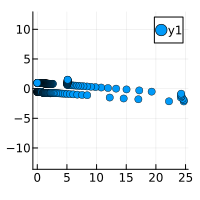

In [202]:
t1 = [1_050,1060,1070][1];
plot(size=(200,200), aspect_ratio=:equal)
scatter!(_ys[t1])

In [258]:
s = 4
t1 = [1_050, 1060, 1070][3];
t2 = t1 + s

# Integrate the controls 
# for each time step t=1,...,s
# ux  = sum([u.dx  for u in _us[t1:t2-1]])
# uhd = sum([u.dhd for u in _us[t1:t2-1]])
# u   = Control( rot(-_hds[t1])*ux, uhd)
u = Control([0.;0.], 0.0)

# Observation and map
p  = Pose(u.dx, u.dhd)
x  = _ys[t2]
y  = _ys_inf[t1]


# Create the grid and 
# set the observation and map
dx  = 2.5
dhd = 45/360*2π
k   = 8
@time ps_ = pose_grid(p, k, dx, dhd)

x_ = CuArray(stack(x))
y_ = CuArray(stack(y))

# Compute sensor measurements and 
# Gaussian mixture components
w = 20
@time z_       = cast_cu(ps_, y_; fov=π, zmax=_zmax, cell_rad=0.1)
@time y_tilde_ = get_ys_tilde_cu(z_, as_, w);

println("k=$(k), w=$(w)")
size(y_tilde_), size(z_)

  0.000399 seconds (396 allocations: 20.391 KiB)
  0.000253 seconds (63 allocations: 3.359 KiB)
  0.000916 seconds (243 allocations: 13.188 KiB)
k=8, w=20


((512, 361, 41, 2), (512, 361))

In [259]:
y_tilde = Array(y_tilde_[:,:,w+1,:]);
y_tilde = Float64.(y_tilde)
size(y_tilde)
y_tilde[z_.==_zmax,1] .= Inf
y_tilde[z_.==_zmax,2] .= Inf;


  0.011097 seconds (610 allocations: 55.953 KiB)
(512, 4, 4) (512, 4, 4, 361)
CartesianIndex(222, 4, 2)
-6649.8657485668045
-6649.8657485668045


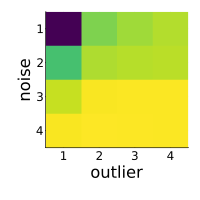

In [264]:
# Sensor args
n = 4
s_noise     = CuArray(range(0.05,  0.3, n))
outlier     = CuArray(range(1e-6,  1e-1, n))
outlier_vol_inv = 1e-2
outlier_vol = 1/outlier_vol_inv


# Evaluate the the observations with respect to the 
# different Gaussian mixtures computed above
@time log_ps_, log_ps_pw_ = sensor_smc_logpdf_cu(
    x_, 
    y_tilde_, 
    reshape(s_noise, 1,1,1,1, n, 1),
    reshape(outlier, 1,1,1,1, 1, n),
    outlier_vol;
    return_pointwise=true
)

# Move everyting back to CPU
ps        = Vector.(eachrow(Array(ps_)))
log_ps    = Array(log_ps_);
log_ps_pw = Array(log_ps_pw_);
log_ps_pw = permutedims(log_ps_pw, [1,3,4,2])

println(size(log_ps), " ", size(log_ps_pw))

I = argmax(log_ps)
println(I)

println(minimum(log_ps[:,1,1]))
println(minimum(log_ps[:,:,:]))

heat = dropdims(maximum(log_ps, dims=1), dims=1)
heatmap(heat, size=(200,200), yflip = true, c=:viridis, legend=nothing, xlabel="outlier", ylabel="noise")

In [265]:
CUDA.allowscalar(true)

I = argmax(log_ps)
println(I)

plts = []

plot_grid = true
plot_rendered_y = true
plot_data_probs = true
for si=1:n, oi=1:n
    i = argmax(log_ps[:,si,oi])
    mypl = plot(size=(200,200), legend=nothing, 
            aspect_ratio=:equal, 
            # xlim=(-5,15), ylim=(-8,8),
            title="sig $(s_noise[si])\nout $(outlier[oi])\nlog $(floor(log_ps[i,si,oi]))", titlefontsize=6)

    # scatter!(_ys[t1], markerstrokewidth=0, c=col[1], markersize=4)
    # scatter!(_ys[t2] .* Pose(ps[i]), markerstrokewidth=0, c=:magenta, markersize=2)
    args = (markerstrokewidth=0, c=col[1], markersize=4)
    if plot_rendered_y
        scatter!(unstack(y_tilde[i,:,:])  .* Pose(ps[i]); args...)
    else
        scatter!(_ys[t1]; args...)
    end

    cs = :magenta
    if plot_data_probs
        ls = log_ps_pw[i,si,oi,:]
        ls = exp.(ls)
        # ls = peak_to_peak(ls)
        perm = sortperm(ls)
        ls = ls[perm]
        cs = cgrad(:viridis)[ls]
    end

    scatter!(_ys[t2][perm] .* Pose(ps[i]), markerstrokewidth=0, c=cs, markersize=2)
    
    if plot_grid
        ls = log_ps[:,si,oi]
        perm = sortperm(ls)
        ls = ls[perm]
        cs = cgrad(:viridis)[peak_to_peak(ls)]
        
        plot!(Pose.(ps[perm]), cs; r=.5, linewidth=1)
    end
    
    # annotate!(-4.5, 6, text(f"noise: {$(s_noise[si])}\noutlier: {$(outlier[oi])}\nlogp: {$(log_ps[i,si,oi]):0.0f}", :left, :top, 7))

    push!(plts, mypl)
end
mypl = plot(plts..., layout=(n,n), size=(1000,1000), plot_title="w:$(w), k:$(k), vol:$(outlier_vol)")
savefig("_imgs/hierarchical_bayes_grid_t$(t1)_w$(w)_k$(k).png")
mypl

CartesianIndex(222, 4, 2)


## SLAM 

In [ ]:
1_050 + 220*s

In [ ]:
p_ref = Pose()

ps = Pose[]
log_ps = []
xs = []
ys = []
ts = []
times = []

t1 = 1_000
s  = 4


yy = []
for i=1:220

    t = t1 + i*s


    ux  = sum([u.dx  for u in _us[t:t+s-1]])
    uhd = sum([u.dhd for u in _us[t:t+s-1]])
    u = Control( rot(-_hds[t])*ux, uhd)

    p = Pose(u.dx,u.dhd)*p_ref

    x  = stack(_ys[t+s])
    
    yy = [yy; _ys[t] .* p_ref]
    y = stack(yy)
#     y = stack( _ys[t] )
    
    y[isnan.(y)] .= Inf
    
    m_ = CuArray(y)

    # Proposal args


    n = 3

    k   = fill(12, n)
    dx  = 1. ./ (k*0.8) .^ collect(range(0,n-1))
    dhd = 35/360*2π ./ (k*0.8) .^ collect(range(0,n-1))

    s_noise     = fill(0.05, n)
    outlier     = fill(1e-9, n)
#     s_noise     = range(0.1, 0.05, n)
#     outlier     = range(1e-1,1e-6,n)
    outlier_vol = fill(1., n)
    w           = fill(15, n)

    grid_args = (k, dx, dhd, m_, as_, w, s_noise, outlier, outlier_vol)

    ms = @elapsed q, log_q, = iterated_proposal(p, x, grid_args...);
    ms = ms*1000
    ms = Int(floor(ms*100))/100
        
    push!(times, ms)
    push!(ps, q)
    push!(log_ps, log_q)
    push!(ys, _ys[t] .* p_ref)
    push!(xs, _ys[t+s])
    push!(ts, t)    
    p_ref = q
    
    
end

println("""
Total:    $(sum(times)) ms
Avg step: $(mean(times)) ms
""")
length(ts), length(ps)
plot(times, size=(300,100), marker=:o, title="Step time", legend=nothing)

In [ ]:
println(length(yy))
plot(log_ps, size=(600,200), marker=:o, title="log_p", legend=nothing)

In [ ]:
FPS = Int(floor(1000/mean(times)))

In [ ]:
mypl = plot(aspect_ratio=:equal, legend=nothing)


plot!(ps[1:end], c=:red)
for (t,(x,p)) in enumerate(zip(xs[1:10:end], ps[1:10:end]))
    scatter!(x.*p, markersize=1, markerstrokewidth=0, c=col[1], alpha=1.)
end

mypl

In [ ]:
length(ps)

In [ ]:
mypl = plot(size=(600,400),aspect_ratio=:equal, legend=nothing, 
#     xlim=(-35,25), 
#     ylim=(-25,5)
)
pp = Pose(0,0,115/360*2π)
plot!([p * pp for p in ps], c=:red, linewidth=2, alpha=1)

In [ ]:
t=100
mypl = plot(size=(600,400),aspect_ratio=:equal, legend=nothing, 
#     xlim=(-35,25), 
#     ylim=(-35,5)
)

pp = Pose(0,0,115/360*2π)
for (x,p) in zip(xs[1:10:end], ps[1:10:end])


    plot!([p*pp], c=:red, alpha=1,linewidth=1,)

    scatter!(x.*(p*pp), markersize=1, markerstrokewidth=0, c=col[1], alpha=1.)
end

mypl

In [ ]:
qs = [p*pp for p in ps];

In [ ]:
length(ps)

In [ ]:
ani = Animation()

for t=1:20:length(ps)
    mypl = plot(size=(600,400),aspect_ratio=:equal, legend=nothing, 
        xlim=(-20,45), 
        ylim=(-25,25))
    
    for (i,x,p) in zip(1:t, xs[1:t], qs[1:t])
        delta = 20
        i_ = 1/delta*(i - t + delta)
        plot!([p], c=:red, alpha=max(i_,0)^2,linewidth=1,)
        
        scatter!(x.*p, markersize=1, markerstrokewidth=0, c=col[1], alpha=0.1)
    end
    frame(ani, mypl)
end

gif(ani,"_imgs/slam_csail.gif", fps=FPS)

In [ ]:
1_000 / (FPS/4)